# Sonos Project

Learn How to build Full Stack App + Machine Learning

## Stock API

https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=BBRI.JK&apikey=MWS5CUQWP4SDJK9L&datatype=csv

## Import Dependencies

In [1]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
import pandas as pd

## Read Original Data

In [2]:
# Reverse the data start from the earlier days
stock_daily_data = pd.read_csv('./daily_BBRI.JK.csv').iloc[::-1]

In [3]:
stock_daily_data.describe()

,open,high,low,close,volume
count,100.000000,100.000000,100.000000,100.000000,1.000000e+02
mean,3354.800000,3424.700000,3269.600000,3330.100000,2.547695e+08
std,760.756508,743.853541,763.877562,751.509585,1.478902e+08
min,2250.000000,2270.000000,2160.000000,2170.000000,7.971070e+07
25%,2737.500000,2837.500000,2657.500000,2767.500000,1.449664e+08
50%,3090.000000,3135.000000,2990.000000,3040.000000,2.078630e+08
75%,4072.500000,4192.500000,4000.000000,4107.500000,3.386146e+08
max,4700.000000,4700.000000,4600.000000,4620.000000,8.726073e+08


In [4]:
stock_daily_data.head(5)

,timestamp,open,high,low,close,volume
99,2020-01-29,4620.0,4660.0,4600.0,4620.0,194871800
98,2020-01-30,4700.0,4700.0,4580.0,4580.0,87726300
97,2020-01-31,4570.0,4580.0,4460.0,4460.0,137055500
96,2020-02-03,4460.0,4490.0,4450.0,4460.0,131584600
95,2020-02-04,4690.0,4690.0,4520.0,4560.0,112377400


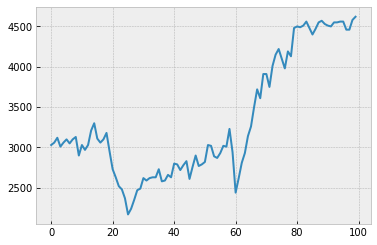

In [5]:
plt.plot(stock_daily_data['close'])

## Start Pre Processing

In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [7]:
future_days = 5

In [8]:
pre_processed_data = stock_daily_data.reset_index(drop=True)

In [9]:
pre_processed_data = pre_processed_data.drop(['timestamp'], 1)

In [10]:
# use today market condition to predict tomorrow price
pre_processed_data['prediction'] = pre_processed_data['close'].shift(-future_days)
pre_processed_data

,open,high,low,close,volume,prediction
0,4620.0,4660.0,4600.0,4620.0,194871800,4560.0
1,4700.0,4700.0,4580.0,4580.0,87726300,4550.0
2,4570.0,4580.0,4460.0,4460.0,137055500,4550.0
3,4460.0,4490.0,4450.0,4460.0,131584600,4500.0
4,4690.0,4690.0,4520.0,4560.0,112377400,4510.0
...,...,...,...,...,...,...
95,3100.0,3110.0,3030.0,3060.0,95377000,NaN
96,3020.0,3060.0,2980.0,3010.0,171421500,NaN
97,3050.0,3140.0,3010.0,3120.0,308484300,NaN
98,3100.0,3110.0,3040.0,3060.0,158209300,NaN


### Removing NaN

In [11]:
# remove NaN row
pre_processed_data = pre_processed_data.dropna()

# remove column
pre_processed_data = pre_processed_data.drop(columns=['volume'])

### Normalize using MinMaxScaler

In [12]:
# normalize the dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
pre_processed_data = scaler.fit_transform(pre_processed_data)

### Split Data test and train

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# split into train and test sets
train, test = train_test_split(pre_processed_data, shuffle=False)
train, test = np.asarray(train), np.asarray(test)

### Create Data Set Function

In [15]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    
    return np.array(dataX), np.array(dataY)

### Reshape Data

In [16]:
# reshape into X=t and Y=t+1
look_back = 4
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [17]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Model Building

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [19]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
 - 5s - loss: 0.3119
Epoch 2/50
 - 0s - loss: 0.1476
Epoch 3/50
 - 0s - loss: 0.0636
Epoch 4/50
 - 1s - loss: 0.0318
Epoch 5/50
 - 1s - loss: 0.0224
Epoch 6/50
 - 0s - loss: 0.0184
Epoch 7/50
 - 1s - loss: 0.0157
Epoch 8/50
 - 0s - loss: 0.0135
Epoch 9/50
 - 1s - loss: 0.0114
Epoch 10/50
 - 1s - loss: 0.0097
Epoch 11/50
 - 1s - loss: 0.0084
Epoch 12/50
 - 1s - loss: 0.0073
Epoch 13/50
 - 1s - loss: 0.0064
Epoch 14/50
 - 1s - loss: 0.0058
Epoch 15/50
 - 1s - loss: 0.0053
Epoch 16/50
 - 0s - loss: 0.0049
Epoch 17/50
 - 0s - loss: 0.0047
Epoch 18/50
 - 0s - loss: 0.0045
Epoch 19/50
 - 0s - loss: 0.0043
Epoch 20/50
 - 0s - loss: 0.0043
Epoch 21/50
 - 0s - loss: 0.0042
Epoch 22/50
 - 0s - loss: 0.0042
Epoch 23/50
 - 0s - loss: 0.0041
Epoch 24/50
 - 0s - loss: 0.0041
Epoch 25/50
 - 0s - loss: 0.0040
Epoch 26/50
 - 0s - loss: 0.0040
Epoch 27/50
 - 0s - loss: 0.0040
Epoch 28/50
 - 0s - loss: 0.0040
Epoch 29/50
 - 0s - loss: 0.0040
Epoch 30/50
 - 0s - loss: 0.0039
Epoch 31/50
 - 0s -

## Evaluation

In [20]:
import math

In [21]:
# make evaluation
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

### Fix operands issue

In [22]:
# assign to new scaler, to avoid operands issue
scale = MinMaxScaler()
scale.min_, scale.scale_ = scaler.min_[0], scaler.scale_[1]

### Invert the Normalizer

In [23]:
# invert evaluation
trainPredict = scale.inverse_transform(trainPredict)
trainY = scale.inverse_transform([trainY])
testPredict = scale.inverse_transform(testPredict)
testY = scale.inverse_transform([testY])

In [24]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 144.33 RMSE
Test Score: 159.37 RMSE


## Post Processing

In [25]:
base_line = stock_daily_data.reset_index(drop=True)
current_prediction_dataset = base_line.drop(columns=['volume', 'timestamp'])
current_prediction_dataset = scaler.fit_transform(current_prediction_dataset)

In [26]:
current_prediction_dataset = np.asarray(current_prediction_dataset)
current_prediction_data_setX, current_prediction_data_setY = create_dataset(current_prediction_dataset, look_back)

In [27]:
current_prediction_data_setX = np.reshape(current_prediction_data_setX, (current_prediction_data_setX.shape[0], 1, current_prediction_data_setX.shape[1]))

### predict the actual result

In [28]:
result = model.predict(current_prediction_data_setX)
result = scale.inverse_transform(result)

## Plotting

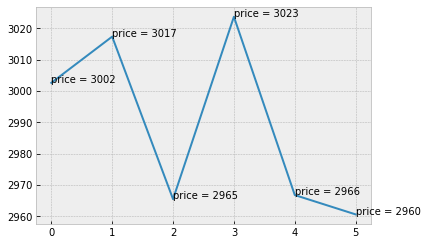

In [29]:
# plot baseline and predictions

future_prediction = result[~future_days:]

plt.plot(future_prediction)

for index, value in enumerate(future_prediction):
    plt.text(index,value,f"price = {int(value)}")

plt.show()